# **Critical Heat Flux Prediction**

This dataset was prepared for the journal article entitled "On the prediction of critical heat flux using a physics-informed machine learning-aided framework" (doi: 10.1016/j.applthermaleng.2019.114540). The dataset contains processed and compiled records of experimental critical heat flux and boundary conditions used for the work presented in the article.

The critical heat flux (CHF) corresponding to the departure from nucleate boiling (DNB) crisis is essential to the design and safety of a two-phase flow boiling system. Despite the abundance of predictive tools available to the thermal engineering community, the path for an accurate, robust CHF model remains elusive due to lack of consensus on the DNB triggering mechanism. This work aims to apply a physics-informed machine learning (ML)-aided hybrid framework to achieve superior predictive capabilities. Such a hybrid approach takes advantage of existing understanding in the field of interest (i.e., domain knowledge) and uses ML to capture undiscovered information from the mismatch between the actual and domain knowledge-predicted target.

The reliability and economic competitiveness of a thermal system hinge upon its safety and regulatory measures. During the stage of system design and analysis, researchers and engineers typically leverage extensive experimental efforts and investigate evolutionary models that represent the state-of-the-art understanding in their fields of specialization—also known as *domain knowledge* (DK)—to predict various safety limits.


### **Aim of the model**

The target feature is **chf_exp [MW/m2]** which is a continuous variable. The scoring metric is RMSE.

### **Importing libraries and setting display options**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.pandas.set_option('display.max_columns',None) #displays all columns
pd.set_option('display.max_rows', 250) #displays all rows
import random
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ReduceLROnPlateau
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt # for hyperparameter tuning
from keras.callbacks import EarlyStopping, TensorBoard
import pickle
import shap
shap.initjs()

### **Accessing and reading te dataset**

In [2]:
heat_flux_df = pd.read_csv("Data_CHF_Zhao_2020_ATE.csv")
heat_flux_df.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


### **Creating a copy of raw data**

In [3]:
heat_flux_df1 = heat_flux_df.copy(deep= True)
heat_flux_df1.sample(10)

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
1277,1278,Weatherhead,tube,13.79,1343,0.1113,7.7,7.7,457,1.8
236,237,Thompson,tube,6.89,4055,-0.0329,10.3,10.3,762,4.9
1715,1716,Janssen,annulus,6.89,2767,0.0108,12.7,38.1,914,3.6
1270,1271,Weatherhead,tube,13.79,1627,0.1524,7.7,7.7,457,1.4
914,915,Thompson,tube,13.79,5398,-0.3559,4.7,4.7,318,10.2
1184,1185,Thompson,tube,18.27,793,-0.1258,3.0,3.0,150,1.1
1080,1081,Thompson,tube,13.79,1533,0.1587,7.8,7.8,591,1.9
45,46,Thompson,tube,2.14,6510,-0.0185,1.1,1.1,114,7.3
917,918,Thompson,tube,13.79,5588,0.0192,4.7,4.7,318,4.7
962,963,Thompson,tube,13.79,694,-0.0573,7.7,7.7,457,3.6


# **Exploratory Data Analysis (EDA)**

In [4]:
heat_flux_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1865 non-null   int64  
 1   author               1865 non-null   object 
 2   geometry             1865 non-null   object 
 3   pressure [MPa]       1865 non-null   float64
 4   mass_flux [kg/m2-s]  1865 non-null   int64  
 5   x_e_out [-]          1865 non-null   float64
 6   D_e [mm]             1865 non-null   float64
 7   D_h [mm]             1865 non-null   float64
 8   length [mm]          1865 non-null   int64  
 9   chf_exp [MW/m2]      1865 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 145.8+ KB


In [5]:
display("Basic statistics of the dataset: ")

heat_flux_df1.describe(include= "all").T

'Basic statistics of the dataset: '

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1865.0,NaN,NaN,NaN,933.0,538.523444,1.0,467.0,933.0,1399.0,1865.0
author,1865,10,Thompson,1202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geometry,1865,3,tube,1439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressure [MPa],1865.0,NaN,NaN,NaN,10.010949,4.282715,0.1,6.89,10.34,13.79,20.68
mass_flux [kg/m2-s],1865.0,NaN,NaN,NaN,2862.647721,1656.412247,0.0,1519.0,2590.0,3933.0,7975.0
x_e_out [-],1865.0,NaN,NaN,NaN,0.016179,0.117575,-0.8667,-0.0483,0.0244,0.1006,0.232
D_e [mm],1865.0,NaN,NaN,NaN,9.417212,6.333807,1.0,5.6,8.5,11.1,37.5
D_h [mm],1865.0,NaN,NaN,NaN,16.167721,21.18287,1.0,5.6,10.3,15.2,120.0
length [mm],1865.0,NaN,NaN,NaN,911.340483,726.718974,10.0,432.0,625.0,1778.0,3048.0
chf_exp [MW/m2],1865.0,NaN,NaN,NaN,3.854638,1.985535,0.8,2.4,3.5,4.8,19.3


In [6]:
# to get insight into categorical variables
heat_flux_df1.describe(include = ['O'])

,author,geometry
count,1865,1865
unique,10,3
top,Thompson,tube
freq,1202,1439


In [7]:
display("Total of duplicate instances: ")
heat_flux_df1.duplicated().sum()

'Total of duplicate instances: '

0

In [8]:
display("Total of unique values : ")
heat_flux_df1.nunique()

'Total of unique values : '

id                     1865
author                   10
geometry                  3
pressure [MPa]          114
mass_flux [kg/m2-s]     578
x_e_out [-]            1360
D_e [mm]                 36
D_h [mm]                 41
length [mm]              54
chf_exp [MW/m2]         109
dtype: int64

# **Preprocessing**

In [9]:
display("Dropping columns that are not contributing to the objective of the project: ")

columns_to_drop = ["id"]
heat_flux_df1.drop(labels= columns_to_drop, axis= 1, inplace= True)

heat_flux_df1.sample(10)

'Dropping columns that are not contributing to the objective of the project: '

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
1729,Janssen,annulus,6.89,5588,0.0381,6.4,15.9,914,3.5
1292,Weatherhead,tube,13.79,1354,-0.0576,7.7,7.7,457,3.2
175,Thompson,tube,6.96,2061,0.0716,5.6,5.6,216,6.4
392,Thompson,tube,6.89,2577,0.0340,12.4,12.4,610,4.3
501,Thompson,tube,6.89,7405,-0.0054,23.6,23.6,1972,3.8
1493,Beus,annulus,11.03,3677,0.0765,5.6,15.2,2134,1.8
1815,Mortimore,annulus,8.27,2726,0.0627,5.0,13.3,2134,2.3
1331,Weatherhead,tube,13.79,1804,0.0897,11.1,11.1,457,1.7
261,Thompson,tube,6.89,7269,-0.0035,10.3,10.3,762,4.2
1596,Janssen,annulus,6.89,1519,0.1590,12.7,42.3,1778,2.7


In [10]:
# Rename columns for better understanding

rename_columns = ["author", "shape", "pressure", "mass_flux", "exit_concentration", "equivalent_diameter", "hydraulic_diameter", "channel_length", "exp_critical_heat_flux"]
heat_flux_df1.columns = rename_columns
heat_flux_df1.columns

Index(['author', 'shape', 'pressure', 'mass_flux', 'exit_concentration',
       'equivalent_diameter', 'hydraulic_diameter', 'channel_length',
       'exp_critical_heat_flux'],
      dtype='object')

In [11]:
display("Missing values in dataset: ")

heat_flux_df1.isnull().sum()

'Missing values in dataset: '

author                    0
shape                     0
pressure                  0
mass_flux                 0
exit_concentration        0
equivalent_diameter       0
hydraulic_diameter        0
channel_length            0
exp_critical_heat_flux    0
dtype: int64

**Observation**

Since we have no null values we do not need to do any treatment of missing values

In [12]:
display("Checking correlation among the vectors")
heat_flux_df1.iloc[::, 2:].corr(method="pearson")

'Checking correlation among the vectors'

,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length,exp_critical_heat_flux
pressure,1.000000,-0.165660,-0.296783,-0.400600,-0.514806,-0.190572,-0.356977
mass_flux,-0.165660,1.000000,-0.223631,-0.046866,-0.242915,-0.062630,0.453562
exit_concentration,-0.296783,-0.223631,1.000000,0.110438,0.080584,0.378102,-0.513687
equivalent_diameter,-0.400600,-0.046866,0.110438,1.000000,0.493515,0.373820,-0.082771
hydraulic_diameter,-0.514806,-0.242915,0.080584,0.493515,1.000000,0.186977,0.099406
channel_length,-0.190572,-0.062630,0.378102,0.373820,0.186977,1.000000,-0.423167
exp_critical_heat_flux,-0.356977,0.453562,-0.513687,-0.082771,0.099406,-0.423167,1.000000


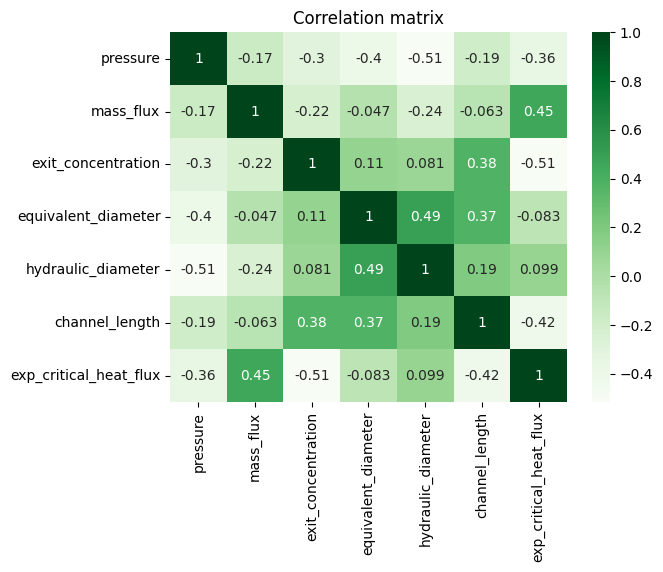

In [13]:
sns.heatmap(heat_flux_df1.iloc[::, 2:].corr(method="pearson"), annot= True, cmap= "Greens")
plt.title("Correlation matrix");

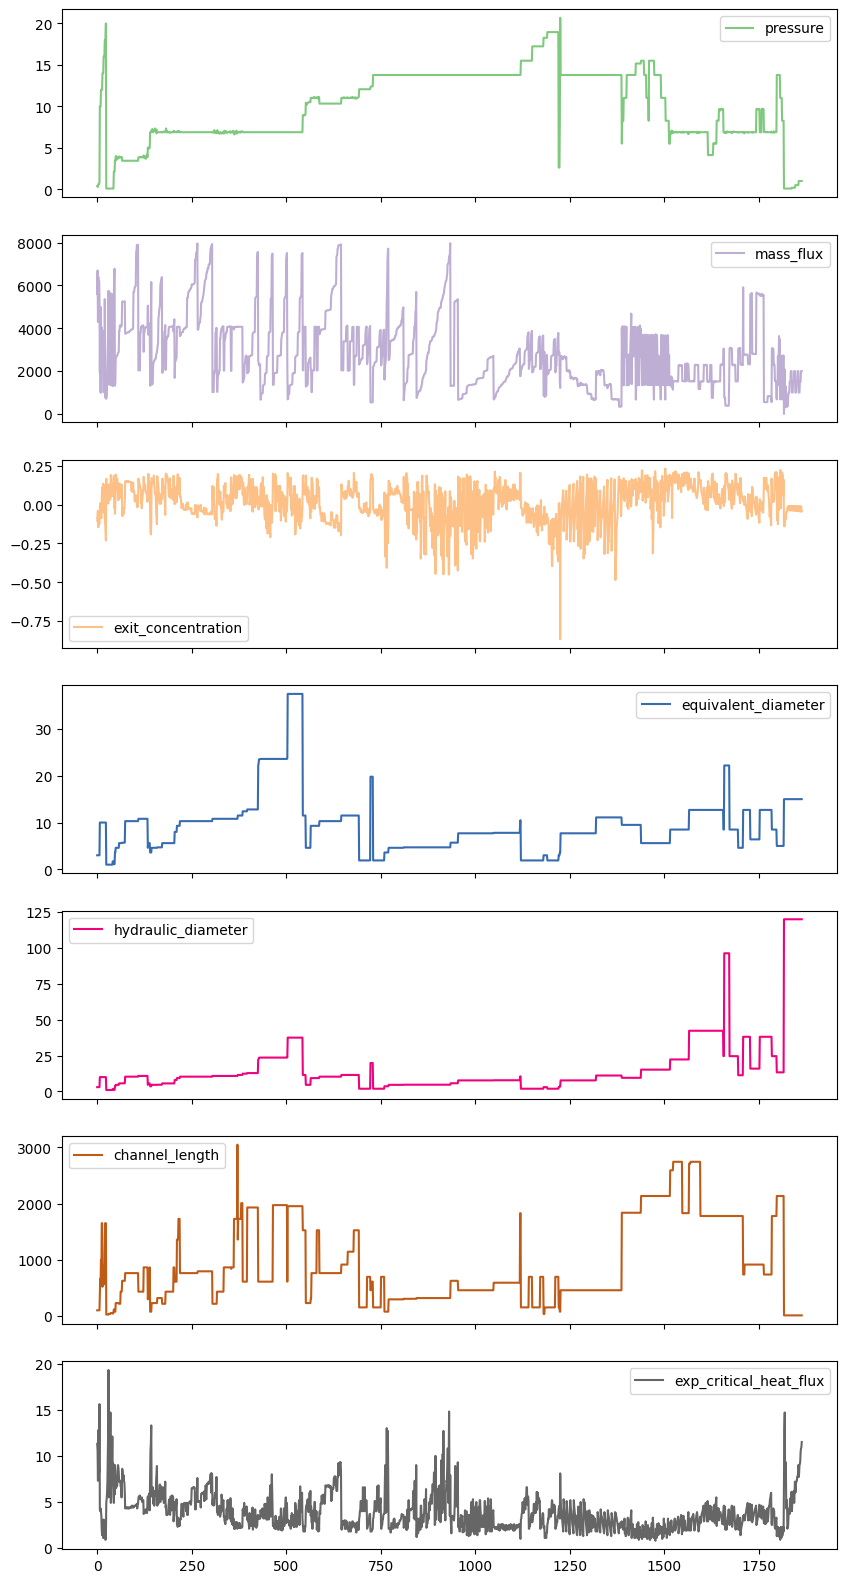

In [14]:
#  Checking distribution for each variable using subplots 
heat_flux_df1.plot(figsize = (10,20), subplots = True, cmap = "Accent");

In [15]:
# Checkpoint
heat_flux_df1.to_csv("./heat_flux_ready_for_model_building.csv", index= False)

# **Feature Selection**

*Reference : https://www.shedloadofcode.com/blog/eight-ways-to-perform-feature-selection-with-scikit-learn*



In [16]:
# Dividing data into dataset and 

In [22]:
# # Instantiate RandomForestRegressor
# rf_feature_selection = RandomForestRegressor(n_estimators= 100)

# # Fitting the dataset and target variable
# rf_feature_selection.fit(x, y)

# # Get feature importances
# importances = rf_feature_selection.feature_importances_

# # Sort feature importances in descending order
# sorted_indices = importances.argsort()[::-1]

# # Select the top k features
# k = len(x.columns)
# selected_features = x.columns[sorted_indices[:k]]
# top_importances = importances[sorted_indices[:k]]

# # Plot the feature importances
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(top_importances)), top_importances, tick_label=selected_features)
# plt.xticks(rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Tree-Based Methods: Feature Importances')
# plt.show()

# print("Selected Features:")
# print(selected_features)



# **train_test_split**

### **Splitting dataset into dataset and target variable**

In [16]:
x = heat_flux_df1.drop("exp_critical_heat_flux", axis = 1)
y = heat_flux_df1["exp_critical_heat_flux"]

display("Shape of train data:", x.shape)
display("Sample of train data:", x.sample())
display("Shape of target variable: ", y.shape )

'Shape of train data:'

(1865, 8)

'Sample of train data:'

,author,shape,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length
1171,Thompson,tube,17.24,3621,-0.022,1.9,1.9,152


'Shape of target variable: '

(1865,)

###  **Dividing data into training data and testing data**


In [17]:
# train ad test dataset
x_train, x_to_test, y_train, y_to_test  = train_test_split(x, y, test_size= 0.25, random_state= 5, stratify= x[["shape","author"]])
display("Train dataset: ", x_train.shape, x_train.sample(5), x_train["shape"].unique())
display("Test dataset: ", x_to_test.shape, x_to_test.sample(5))
display("Shape of y_train: ", y_train.shape)

'Train dataset: '

(1398, 8)

,author,shape,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length
519,Thompson,tube,6.89,1899,-0.0594,37.5,37.5,1953
1544,Janssen,annulus,6.85,2265,0.1017,8.5,22.3,2743
1808,Mortimore,annulus,11.03,1370,0.1031,5.0,13.3,2134
109,Thompson,tube,3.86,2034,0.1671,10.8,10.8,432
870,Thompson,tube,13.79,2048,-0.3209,4.7,4.7,318


array(['tube', 'annulus', 'plate'], dtype=object)

'Test dataset: '

(467, 8)

,author,shape,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length
787,Thompson,tube,13.79,3526,0.0646,4.6,4.6,295
1664,Janssen,annulus,6.92,381,0.1594,22.2,96.3,1778
459,Thompson,tube,6.89,5357,-0.0027,23.6,23.6,610
527,Thompson,tube,6.89,2712,-0.1138,37.5,37.5,1953
330,Thompson,tube,6.79,4001,-0.0975,10.8,10.8,432


'Shape of y_train: '

(1398,)

In [18]:
#Dividing training data into train and validation dataset

# Note: you can pass argument to stratify data only and only if you have "shuffle = True" 
x_val, x_test, y_val, y_test = train_test_split(x_to_test, y_to_test, test_size= 0.25, shuffle= True, random_state= 5, stratify= x_to_test[["shape","author"]])
display("Validation data: ", x_val.shape, x_val.sample(5))
display("Shape of y_val: ", y_val.shape)
display("Testing data: ", x_test.shape, x.sample(5))
display("Shape of y_test: ", y_test.shape)

'Validation data: '

(350, 8)

,author,shape,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length
1642,Janssen,annulus,8.30,1519,0.0052,12.7,42.3,1778
418,Thompson,tube,6.89,5398,-0.0166,12.8,12.8,1930
1094,Thompson,tube,13.79,2089,0.0244,7.8,7.8,591
717,Thompson,tube,12.07,2835,-0.0740,1.9,1.9,696
262,Thompson,tube,6.89,7554,-0.0416,10.3,10.3,762


'Shape of y_val: '

(350,)

'Testing data: '

(117, 8)

,author,shape,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length
1819,Kossolapov,plate,0.10,2078,-0.1392,15.0,120.0,10
405,Thompson,tube,6.89,2699,0.0463,12.8,12.8,1930
184,Thompson,tube,7.00,3513,0.1888,5.6,5.6,432
240,Thompson,tube,6.89,5438,0.0130,10.3,10.3,762
1362,Weatherhead,tube,13.79,686,-0.1825,11.1,11.1,457


'Shape of y_test: '

(117,)

### **Encoding data**

We will encode categorical data using `pd.get_dummies`

In [19]:
# Encoding train data
columns_to_encode = ["author", "shape"]
x_train_encoded = pd.get_dummies(x_train, sparse = True, columns = columns_to_encode, dtype= int)
display("Shape of x_train_encoded: ", x_train_encoded.shape)
x_train_encoded.sample(5)
display("Data Types in x_train_encoded: ", x_train_encoded.dtypes)

'Shape of x_train_encoded: '

(1398, 19)

'Data Types in x_train_encoded: '

pressure                        float64
mass_flux                         int64
exit_concentration              float64
equivalent_diameter             float64
hydraulic_diameter              float64
channel_length                    int64
author_Beus            Sparse[int32, 0]
author_Inasaka         Sparse[int32, 0]
author_Janssen         Sparse[int32, 0]
author_Kossolapov      Sparse[int32, 0]
author_Mortimore       Sparse[int32, 0]
author_Peskov          Sparse[int32, 0]
author_Richenderfer    Sparse[int32, 0]
author_Thompson        Sparse[int32, 0]
author_Weatherhead     Sparse[int32, 0]
author_Williams        Sparse[int32, 0]
shape_annulus          Sparse[int32, 0]
shape_plate            Sparse[int32, 0]
shape_tube             Sparse[int32, 0]
dtype: object

In [20]:
# Encoding validation data
x_val_encoded = pd.get_dummies(x_val, sparse = True, columns= ["author", "shape"], dtype = int)
display("Shape of x_val_encoded: ", x_val_encoded.shape)
x_val_encoded.sample(5)
display("Data Types in x_val_encoded: ", x_val_encoded.dtypes)

'Shape of x_val_encoded: '

(350, 19)

'Data Types in x_val_encoded: '

pressure                        float64
mass_flux                         int64
exit_concentration              float64
equivalent_diameter             float64
hydraulic_diameter              float64
channel_length                    int64
author_Beus            Sparse[int32, 0]
author_Inasaka         Sparse[int32, 0]
author_Janssen         Sparse[int32, 0]
author_Kossolapov      Sparse[int32, 0]
author_Mortimore       Sparse[int32, 0]
author_Peskov          Sparse[int32, 0]
author_Richenderfer    Sparse[int32, 0]
author_Thompson        Sparse[int32, 0]
author_Weatherhead     Sparse[int32, 0]
author_Williams        Sparse[int32, 0]
shape_annulus          Sparse[int32, 0]
shape_plate            Sparse[int32, 0]
shape_tube             Sparse[int32, 0]
dtype: object

In [21]:
# Encoding test data
x_test_encoded = pd.get_dummies(x_test, sparse = True, columns = ["author", "shape"], dtype = int)
display("Shape of x_test_encoded: ", x_test_encoded.shape)
x_test_encoded.sample(5)
display("Data Types in x_test_encoded: ", x_test_encoded.dtypes)

'Shape of x_test_encoded: '

(117, 19)

'Data Types in x_test_encoded: '

pressure                        float64
mass_flux                         int64
exit_concentration              float64
equivalent_diameter             float64
hydraulic_diameter              float64
channel_length                    int64
author_Beus            Sparse[int32, 0]
author_Inasaka         Sparse[int32, 0]
author_Janssen         Sparse[int32, 0]
author_Kossolapov      Sparse[int32, 0]
author_Mortimore       Sparse[int32, 0]
author_Peskov          Sparse[int32, 0]
author_Richenderfer    Sparse[int32, 0]
author_Thompson        Sparse[int32, 0]
author_Weatherhead     Sparse[int32, 0]
author_Williams        Sparse[int32, 0]
shape_annulus          Sparse[int32, 0]
shape_plate            Sparse[int32, 0]
shape_tube             Sparse[int32, 0]
dtype: object

# **Baseline Model**

### **Scaling / Standardising data using Standard Scalar**

*Reference : https://www.turing.com/kb/data-normalization-with-python-scikit-learn-tips-tricks-for-data-science*

*Reference :https://scikit-learn.org/stable/modules/preprocessing.html*

In [22]:
# Instantiating standardisation of the dataset
standardising_data = StandardScaler()

#  standardising train data
train_data_scaled = standardising_data.fit_transform(x_train_encoded)
display("Standardised train data: ", train_data_scaled)

#  standardising validation data
validation_data_scaled = standardising_data.fit_transform(x_val_encoded)
display("Standardised validation data: ", validation_data_scaled)

#  standardising test data
test_data_scaled = standardising_data.fit_transform(x_test_encoded)
display("Standardised test data: ", test_data_scaled)


c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'Standardised train data: '

array([[-0.2586556 ,  0.76475509,  0.40772711, ..., -0.50379724,
        -0.16257834,  0.54373166],
       [ 0.47906493, -0.15679217, -0.57610775, ..., -0.50379724,
        -0.16257834,  0.54373166],
       [-0.737939  , -1.15739979,  0.54215373, ..., -0.50379724,
        -0.16257834,  0.54373166],
       ...,
       [ 0.07261381,  0.68940069, -0.60299308, ..., -0.50379724,
        -0.16257834,  0.54373166],
       [ 0.88316662, -1.5384954 ,  0.5278709 , ..., -0.50379724,
        -0.16257834,  0.54373166],
       [-1.54614239,  0.62207586,  1.06641757, ..., -0.50379724,
        -0.16257834,  0.54373166]])

c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'Standardised validation data: '

array([[ 0.90099705, -0.13767754, -0.11625274, ..., -0.50446039,
        -0.16245911,  0.54433105],
       [-0.69211762,  1.51432201, -0.3407245 , ..., -0.50446039,
        -0.16245911,  0.54433105],
       [ 1.93536716, -1.22353564, -1.27950721, ..., -0.50446039,
        -0.16245911,  0.54433105],
       ...,
       [ 1.69755439, -0.40718257, -0.69242722, ..., -0.50446039,
        -0.16245911,  0.54433105],
       [-0.69211762, -0.11295784, -0.01537677, ..., -0.50446039,
        -0.16245911,  0.54433105],
       [-0.69211762, -0.07195931, -0.09171534, ...,  1.98231619,
        -0.16245911, -1.83711731]])

c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'Standardised test data: '

array([[ 0.82507066, -0.84775913, -2.31831603, ..., -0.50800051,
        -0.16222142,  0.54772256],
       [-0.73509036,  2.24436274, -0.4076374 , ..., -0.50800051,
        -0.16222142,  0.54772256],
       [-0.73509036,  2.11620732, -0.36883333, ..., -0.50800051,
        -0.16222142,  0.54772256],
       ...,
       [ 0.82507066, -0.86117075,  0.89482963, ..., -0.50800051,
        -0.16222142,  0.54772256],
       [-0.73509036, -0.42355478, -0.09804841, ...,  1.96850197,
        -0.16222142, -1.82574186],
       [-0.10424264,  1.21365545,  0.22672478, ...,  1.96850197,
        -0.16222142, -1.82574186]])

In [23]:
data_chf = heat_flux_df1.drop(labels= ["author","shape"], axis=1)
data_chf.columns

Index(['pressure', 'mass_flux', 'exit_concentration', 'equivalent_diameter',
       'hydraulic_diameter', 'channel_length', 'exp_critical_heat_flux'],
      dtype='object')

In [24]:
# We need to standardize the data in such a way that mean becomes 0 and standard deviation becomes 1 approximately
data_without_chf = data_chf.drop("exp_critical_heat_flux",axis=1)
scaler = StandardScaler()
scaler.fit(data_without_chf)
scaled_features = scaler.transform(data_without_chf)

In [25]:
data_chf.describe().T

,count,mean,std,min,25%,50%,75%,max
pressure,1865.0,10.010949,4.282715,0.1000,6.8900,10.3400,13.7900,20.680
mass_flux,1865.0,2862.647721,1656.412247,0.0000,1519.0000,2590.0000,3933.0000,7975.000
exit_concentration,1865.0,0.016179,0.117575,-0.8667,-0.0483,0.0244,0.1006,0.232
equivalent_diameter,1865.0,9.417212,6.333807,1.0000,5.6000,8.5000,11.1000,37.500
hydraulic_diameter,1865.0,16.167721,21.182870,1.0000,5.6000,10.3000,15.2000,120.000
channel_length,1865.0,911.340483,726.718974,10.0000,432.0000,625.0000,1778.0000,3048.000
exp_critical_heat_flux,1865.0,3.854638,1.985535,0.8000,2.4000,3.5000,4.8000,19.300


In [26]:
# Save the scaler object for future use
pickle.dump(scaler, open("./model/scaler.pkl", "wb"))

### **Deep Learning Model**

In [27]:
# instantiating callback class 
# Note: all values inside the class with numeric values are hyperparameters which can be optimised
# Reference : https://keras.io/api/callbacks/reduce_lr_on_plateau/ 

callback = ReduceLROnPlateau(monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.01) 

In [28]:
# Reference : https://keras.io/api/layers/regularization_layers/dropout/


# Instantiating the Sequential model
model = Sequential()

#  First / Input layer of the model
model.add(Dense(16, input_dim = train_data_scaled.shape[1], use_bias= True, activation= "relu" ))
model.add(Dropout(0.1))

#Hidden layer
model.add(Dense(8, activation= "relu"))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(1, activation= "sigmoid"))

# Compiling the model
model.compile(loss= "mean_squared_error", optimizer = Adam(learning_rate= 0.001))

model.summary()

c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 465 (1.82 KB)

 Trainable params: 465 (1.82 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Fitting the model
epochs = 40
batch_size = 32
model_history = model.fit(x = train_data_scaled,y = y_train, epochs = epochs, validation_data= (validation_data_scaled,y_val),batch_size = batch_size, verbose = 2, callbacks = [callback])

Epoch 1/40
44/44 - 8s - 171ms/step - loss: 14.1483 - val_loss: 12.9702 - learning_rate: 0.0010
Epoch 2/40
44/44 - 0s - 3ms/step - loss: 13.0423 - val_loss: 12.0395 - learning_rate: 0.0010
Epoch 3/40
44/44 - 0s - 3ms/step - loss: 12.4496 - val_loss: 11.7212 - learning_rate: 0.0010
Epoch 4/40
44/44 - 0s - 3ms/step - loss: 12.2274 - val_loss: 11.6227 - learning_rate: 0.0010
Epoch 5/40
44/44 - 0s - 3ms/step - loss: 12.1580 - val_loss: 11.5804 - learning_rate: 0.0010
Epoch 6/40
44/44 - 0s - 3ms/step - loss: 12.1229 - val_loss: 11.5595 - learning_rate: 0.0010
Epoch 7/40
44/44 - 0s - 3ms/step - loss: 12.0927 - val_loss: 11.5471 - learning_rate: 0.0010
Epoch 8/40
44/44 - 0s - 3ms/step - loss: 12.0772 - val_loss: 11.5407 - learning_rate: 0.0010
Epoch 9/40
44/44 - 0s - 3ms/step - loss: 12.0747 - val_loss: 11.5368 - learning_rate: 0.0010
Epoch 10/40
44/44 - 0s - 3ms/step - loss: 12.0675 - val_loss: 11.5345 - learning_rate: 0.0010
Epoch 11/40
44/44 - 0s - 3ms/step - loss: 12.0603 - val_loss: 11.53

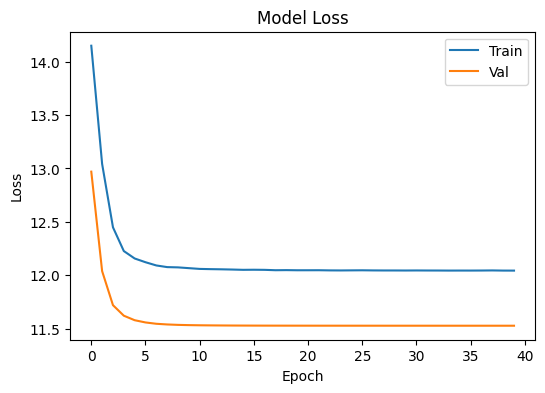

In [30]:
# Plotting the loss
plt.figure(figsize=(6,4))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss']) 
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'],loc='upper right') 
plt.show()

In [31]:
# Predicting on test dataset

y_pred_test = model.predict(test_data_scaled)

# Calculate the mean squared error and r2 score
mse = mean_squared_error(y_test, y_pred_test)

# Calculate the metrics
r2 = r2_score(y_test, y_pred_test)
print('R2 Score:', r2)
print("Mean Square Error:",mse)
print("Root Mean Square Error:",np.sqrt(mse))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
R2 Score: -1.9492484755184334
Mean Square Error: 14.308597085879141
Root Mean Square Error: 3.7826706287858505


**Saving the Model**

*Reference : https://keras.io/guides/serialization_and_saving/*

*Reference : https://docs.fileformat.com/misc/h5/*



In [32]:
model.save("./model/heat_flux_keras_model.h5")

# **Hyperparameter tuning with Keras Tuner**

In [33]:
# Code a function to build a model_for_tuning for keras tuner
def model_for_tuning(hp):
    """Builds model_for_tuning for Keras Tuner

    Args:
      hp: HyperParameters

    Returns:
      keras model_for_tuning: returns a compiled keras sequential model_for_tuning
    """
    model_for_tuning = keras.Sequential()
    model_for_tuning.add(keras.layers.Flatten(input_shape= [train_data_scaled.shape[1]])) # input shape or dimension is the number of vectors in the dataset, should be given as a list -- input layer

    # Tune the number of units in the Dense layers
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=5, step=1)): # for loop to iterate over the number of layers in the model_for_tuning
        model_for_tuning.add(keras.layers.Dense(units=hp.Int(f'dense_units_{i}', min_value=32, max_value=512, step=32), activation='relu')) # hyperparameter for number of neurons in each layer

    model_for_tuning.add(keras.layers.Dense(1, activation='linear')) # this is the output layer

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    metrics = [keras.metrics.RootMeanSquaredError(name="rmse")]
    
    model_for_tuning.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.MeanSquaredError(),
                  metrics=metrics)
    
    return model_for_tuning



In [34]:
# Callbacks

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# TensorBoard Callback
tensorboard = TensorBoard(log_dir='../model/tensorboard_logs')

In [35]:
# Hyperparameter tuning

tuner = kt.RandomSearch(
    model_for_tuning,
    objective='val_loss',
    max_trials=10,
    directory='../heat_flux_prediction/model/tuner_logs'
)

Reloading Tuner from ../heat_flux_prediction/model/tuner_logs\untitled_project\tuner0.json


In [36]:
# Create K-Fold Cross-Validation
K = 10  # Number of folds
kfold = KFold(n_splits=K, shuffle=True)

In [37]:
# Split the data for cross-validation
X_train_for_cv, X_testing, y_train_for_cv, y_testing = train_test_split(x_train, y_train, test_size=0.2, random_state=32, shuffle=False)

In [38]:
X_train_for_cv.dtypes
# X_train_for_cv.head()

author                  object
shape                   object
pressure               float64
mass_flux                int64
exit_concentration     float64
equivalent_diameter    float64
hydraulic_diameter     float64
channel_length           int64
dtype: object

In [39]:
X_train_for_cv.head()

,author,shape,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length
548,Thompson,tube,8.93,4069,0.0656,11.5,11.5,1524
700,Thompson,tube,12.07,2577,-0.0515,1.9,1.9,152
436,Thompson,tube,6.89,957,0.0816,23.6,23.6,610
1411,Williams,tube,13.79,3404,0.0150,9.5,9.5,1836
1255,Weatherhead,tube,13.79,1736,-0.0846,7.7,7.7,457


In [40]:
X_testing.dtypes

author                  object
shape                   object
pressure               float64
mass_flux                int64
exit_concentration     float64
equivalent_diameter    float64
hydraulic_diameter     float64
channel_length           int64
dtype: object

In [41]:
X_testing.head()

,author,shape,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length
1792,Janssen,annulus,6.89,2306,0.1504,8.5,24.6,1778
1111,Thompson,tube,13.79,2767,0.0788,7.8,7.8,591
640,Thompson,tube,10.34,7880,-0.1179,10.3,10.3,762
973,Thompson,tube,13.79,936,-0.2364,7.7,7.7,457
1779,Janssen,annulus,6.89,833,-0.0762,12.7,38.1,737


In [42]:
X_train_for_cv.shape, X_testing.shape, y_train_for_cv.shape, y_testing.shape

((1118, 8), (280, 8), (1118,), (280,))

In [43]:
# Encoding x_train_for_cv - dataset without target variable
x_train_for_cv_encoded = pd.get_dummies(X_train_for_cv, sparse = True, columns = ["author", "shape"], dtype = int)
display("Shape of x_train_for_cv_encoded: ", x_train_for_cv_encoded.shape)
display("dtypes of x_train_for_cv_encoded: ", x_train_for_cv_encoded.dtypes)
display("Sample data of x_train_for_cv_encoded: ", x_train_for_cv_encoded.sample(5))


'Shape of x_train_for_cv_encoded: '

(1118, 19)

'dtypes of x_train_for_cv_encoded: '

pressure                        float64
mass_flux                         int64
exit_concentration              float64
equivalent_diameter             float64
hydraulic_diameter              float64
channel_length                    int64
author_Beus            Sparse[int32, 0]
author_Inasaka         Sparse[int32, 0]
author_Janssen         Sparse[int32, 0]
author_Kossolapov      Sparse[int32, 0]
author_Mortimore       Sparse[int32, 0]
author_Peskov          Sparse[int32, 0]
author_Richenderfer    Sparse[int32, 0]
author_Thompson        Sparse[int32, 0]
author_Weatherhead     Sparse[int32, 0]
author_Williams        Sparse[int32, 0]
shape_annulus          Sparse[int32, 0]
shape_plate            Sparse[int32, 0]
shape_tube             Sparse[int32, 0]
dtype: object

'Sample data of x_train_for_cv_encoded: '

,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length,author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,shape_annulus,shape_plate,shape_tube
1655,9.68,2292,0.0297,12.7,42.3,1778,0,0,1,0,0,0,0,0,0,0,1,0,0
588,10.34,3716,-0.0207,10.3,10.3,762,0,0,0,0,0,0,0,1,0,0,0,0,1
1829,0.10,1000,-0.0093,15.0,120.0,10,0,0,0,0,0,0,1,0,0,0,0,1,0
1490,13.79,1349,-0.1462,5.6,15.2,2134,1,0,0,0,0,0,0,0,0,0,1,0,0
772,13.79,2523,0.1500,4.6,4.6,295,0,0,0,0,0,0,0,1,0,0,0,0,1


In [44]:
# Encoding x_train_for_cv - dataset without target variable
x_testing_encoded = pd.get_dummies(X_testing, sparse = True, columns = ["author", "shape"], dtype = int)
display("Shape of x_testing_encoded: ", x_testing_encoded.shape)
display("dtypes of x_testing_encoded: ", x_testing_encoded.dtypes)
display("Sample data of x_testing_encoded: ", x_testing_encoded.sample(5))


'Shape of x_testing_encoded: '

(280, 19)

'dtypes of x_testing_encoded: '

pressure                        float64
mass_flux                         int64
exit_concentration              float64
equivalent_diameter             float64
hydraulic_diameter              float64
channel_length                    int64
author_Beus            Sparse[int32, 0]
author_Inasaka         Sparse[int32, 0]
author_Janssen         Sparse[int32, 0]
author_Kossolapov      Sparse[int32, 0]
author_Mortimore       Sparse[int32, 0]
author_Peskov          Sparse[int32, 0]
author_Richenderfer    Sparse[int32, 0]
author_Thompson        Sparse[int32, 0]
author_Weatherhead     Sparse[int32, 0]
author_Williams        Sparse[int32, 0]
shape_annulus          Sparse[int32, 0]
shape_plate            Sparse[int32, 0]
shape_tube             Sparse[int32, 0]
dtype: object

'Sample data of x_testing_encoded: '

,pressure,mass_flux,exit_concentration,equivalent_diameter,hydraulic_diameter,channel_length,author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,shape_annulus,shape_plate,shape_tube
624,10.34,5845,-0.0997,10.3,10.3,762,0,0,0,0,0,0,0,1,0,0,0,0,1
1383,13.79,340,0.0799,11.1,11.1,457,0,0,0,0,0,0,0,0,1,0,0,0,1
377,6.93,4069,0.0989,11.5,11.5,1727,0,0,0,0,0,0,0,1,0,0,0,0,1
307,6.86,1031,0.0231,10.8,10.8,216,0,0,0,0,0,0,0,1,0,0,0,0,1
474,6.89,1926,0.0414,23.6,23.6,1972,0,0,0,0,0,0,0,1,0,0,0,0,1


In [45]:
# K-Fold Cross-Validation Loop
for train_index, val_index in kfold.split(X_train_for_cv, y_train_for_cv): # for loop to iterate though the index of training dataset and split it into training dataset and target variable
    x_tr_hp, x_val_hp = x_train_for_cv_encoded.iloc[train_index], x_train_for_cv_encoded.iloc[val_index] # here we are taking the index of the training and validation datasets
    y_tr_hp, y_val_hp = y[train_index], y[val_index] # here we are taking index of target variable corresponding to training and validation dataset

    # Hyperparameter tuning with Keras Tuner
    tuner.search(x_tr_hp, y_tr_hp, validation_data=(x_val_hp, y_val_hp), epochs=100, callbacks=[tensorboard, early_stopping])# searching good values for hyperparameters

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0] # we will be getting one model with best hyperparameters

# Test the best model
test_loss, test_rmse = best_model.evaluate(x_testing_encoded, y_testing) # we are testing the model with the best hyperparameters that we get from the above line of code

print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}")


c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.1123 - rmse: 4.2950  
Test Loss: 13.665875434875488, Test RMSE: 3.6967384815216064


Saving the best model

In [46]:
best_model.save('./model/CHF_hyperparam_tunned_mod2.h5')
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,065 (31.50 KB)

 Trainable params: 8,065 (31.50 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps.values)

{'num_dense_layers': 1, 'dense_units_0': 384, 'learning_rate': 0.01, 'dense_units_1': 416, 'dense_units_2': 256, 'dense_units_3': 64, 'dense_units_4': 160}


In [48]:
# Further tunning this version of our model ....

loadmodel = keras.models.load_model("./model/CHF_hyperparam_tunned_mod2.h5") 
loadmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,067 (31.52 KB)

 Trainable params: 8,065 (31.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### **Final Model Retraining**
While final training the model we use TEST split as Validation Split !

In [49]:
model_final = Sequential()
# adding first layer and using relu as an activation function
model_final.add(Dense(320, input_shape=(x_tr_hp.shape[-1],), activation='relu'))
# adding second layer to the sequential model
model_final.add(Dense(352, activation='relu'))
# adding third layer
model_final.add(Dense(128, activation='relu'))
# Adding fourth layer 
model_final.add(Dense(480, activation='relu'))
# Output layer with linear activation function
model_final.add(Dense(1, activation='linear'))

c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
### Compiling the model

metrics = [keras.metrics.RootMeanSquaredError(name="rmse")]

### choosing an appropirate optimiser and loss function
model_final.compile(optimizer=keras.optimizers.Adam(0.005),
              loss='mean_squared_error',
              metrics=metrics)

In [51]:
# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# TensorBoard Callback
tensorboard = TensorBoard(log_dir='./model/tb_logs')

In [52]:
### Training the model
epochs = 300
batch_size = 32
history = model_final.fit(x_train_for_cv_encoded,y_train_for_cv, validation_data = (x_testing_encoded, y_testing), epochs=epochs, batch_size=batch_size, callbacks=[tensorboard,early_stopping])

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 137540.7656 - rmse: 337.8351 - val_loss: 5.3419 - val_rmse: 2.3113
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.6789 - rmse: 4.2884 - val_loss: 4.5281 - val_rmse: 2.1279
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4137 - rmse: 2.3256 - val_loss: 3.8336 - val_rmse: 1.9580
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4047 - rmse: 2.0948 - val_loss: 3.6297 - val_rmse: 1.9052
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2514 - rmse: 2.2769 - val_loss: 6.2390 - val_rmse: 2.4978
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3408 - rmse: 2.0810 - val_loss: 4.6404 - val_rmse: 2.1541
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2799 - rmse: 2.0681 - val_loss: 3.7289 - val_rmse: 1.9310
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8387 - rmse: 1.9541 - val_loss: 3.8234 - val_rmse: 1.9554
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 

In [53]:
# Saving the final model

model_final.save('./model/CHF_FinalMod_.h5')

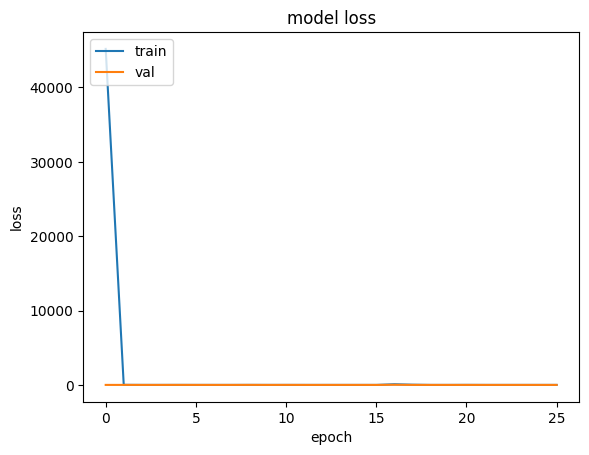

In [54]:
# Plotting loss history of the final model

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

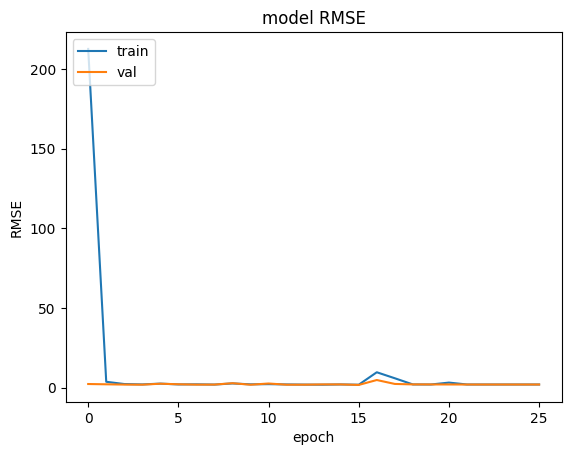

In [55]:
# Plotting metrics history of the final model

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **Deploying Testing**

In [56]:
# Testing a model for deployment

model_for_deployment = keras.models.load_model("./model/CHF_FinalMod_.h5")
model_for_deployment.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 320)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 352)            │       112,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        45,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 480)            │        61,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,979 (886.64 KB)

 Trainable params: 226,977 (886.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [57]:
# Giving testing data as input, but only first row. This input is given after reshaping the values or standardising the values of the entire row between +1 and -1

inp = X_testing.iloc[0].values.reshape(1,-1)

# Reference : https://www.geeksforgeeks.org/how-to-reshape-pandas-series/
# Reference : https://towardsdatascience.com/get-into-shape-14637fe1cd32

# Reference for Pandas values : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.values.html

In [58]:
display(X_testing.iloc[0])

author                 Janssen
shape                  annulus
pressure                  6.89
mass_flux                 2306
exit_concentration      0.1504
equivalent_diameter        8.5
hydraulic_diameter        24.6
channel_length            1778
Name: 1792, dtype: object

In [59]:
display(X_testing.iloc[0].values)

array(['Janssen', 'annulus', 6.89, 2306, 0.1504, 8.5, 24.6, 1778],
      dtype=object)

In [60]:
# loading the pickle file for testing if our code is good to do a prediction on a row of testing data - if you would like to as the below example extract of one row and we can test on it

scaler = pickle.load(open("./model/scaler.pkl", "rb"))

In [61]:
# data_chf.iloc[1700]

pressure                     6.8600
mass_flux                 3052.0000
exit_concentration           0.0318
equivalent_diameter          4.6000
hydraulic_diameter          11.3000
channel_length            1778.0000
exp_critical_heat_flux       2.7000
Name: 1700, dtype: float64

In [61]:
# Predicting the output for test data

y_pred1 = model.predict(x_testing_encoded)
rmse = np.sqrt(mean_squared_error(y_testing, y_pred1))
rmse

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


3.496646352476286

# **Explainable AI**

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html

In [78]:
# Reference :https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html
#  DeepExplainer class is used for Deep Learning models

deep_explainer = shap.DeepExplainer(model_final, x_test_encoded) # instantiating the DeepExplainer class
shap_values_for_final_model = deep_explainer.shap_values(model_final) #getting shap values for final model

c:\Users\Sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


AttributeError: 'tuple' object has no attribute 'as_list'

In [ ]:
#  Plotting a summary plot using shap

shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names=X_testing.columns, max_display=20)

In [79]:
#  Ploting a force plot for one instance or datapoint

shap.force_plot(deep_explainer.expected_value[0].numpy(), shap_values[0][0],feature_names=X_testing.columns)

NameError: name 'explainer' is not defined

In [ ]:
#  Plotting a decision plot

shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][10:30], feature_names=X_testing.columns.to_list())

In [ ]:
# Plotting a waterfall plot

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][80], feature_names=X_testing.columns.to_list(), max_display=20)
